# Imports and Data Preparation

In [811]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Imports for time series analysis
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.vector_ar.var_model import VAR

# Imports for regression
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

# Imports for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from IPython.display import Image

In [806]:
df = pd.read_csv("data_with_calc_fields.csv", sep=';', decimal=",")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index('datetime')
df = df.drop("date", axis=1)

## Feature Engineering

In [807]:
# Add column with 24h max
df["solar_24h_max"] = df.solar_generation_actual.rolling(24,  min_periods=1).max()

# Calculate a moving average FOR EACH HOUR: MOV_AVG_Thur <-- AVG(Mon 1am, Tue 1am, Wed 1am, Thur 1am)
for i in range (24):
    df.loc[df.index.hour == i,"hourly_moving_avg"] = df.loc[df.index.hour == i,"solar_generation_actual"].rolling(4,  min_periods=1).mean()
    df.loc[df.index.hour == i,"hourly_moving_avg_2"] = df.loc[df.index.hour == i,"solar_generation_actual"].rolling(2,  min_periods=1).mean()
    df.loc[df.index.hour == i,"hourly_moving_avg_7"] = df.loc[df.index.hour == i,"solar_generation_actual"].rolling(7,  min_periods=1).mean()
    
# Add columns with forecast errors shiftet by one hour
df["solar_forecast_error_shifted"] = df.solar_forecast_error.shift(1)
df.loc["2016-01-01 00:00:00","solar_forecast_error_shifted"] = 0 # to avoid NaN value
df["wind_forecast_error_shifted"] = df.wind_forecast_error.shift(1)
df.loc["2016-01-01 00:00:00","wind_forecast_error_shifted"] = 0 # to avoid NaN value
df["price_difference_shifted"] = df.price_diff.shift(1)
df.loc["2016-01-01 00:00:00","price_difference_shifted"] = 0 # to avoid NaN value

In [808]:
df.head(3)

,hour,day_ahead_price,intraday_price,price_diff,solar_capacity,solar_generation_actual,wind_capacity,wind_generation_actual,wind_generation_forecast,solar_generation_forecast,...,season,month,weekday,solar_24h_max,hourly_moving_avg,hourly_moving_avg_2,hourly_moving_avg_7,solar_forecast_error_shifted,wind_forecast_error_shifted,price_difference_shifted
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0,23.86,29.34,5.48,39021,0,44325,8648,6033,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2016-01-01 01:00:00,1,22.39,24.28,1.89,39021,0,44325,8579,7421,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,2615.0,5.48
2016-01-01 02:00:00,2,20.59,25.26,4.67,39021,0,44325,8542,7266,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,1158.0,1.89


# Testing different Prediction Methods

## Time Series Analysis

In [414]:
df_SG = df[["solar_generation_actual"]]

In [415]:
model = AR(df_SG)

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [416]:
model_fit = model.fit()
yhat = model_fit.predict(len(df_SG), len(df_SG))
print(yhat)

17542    5.534279
dtype: float64


/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [101]:
model = ARMA(df_SG, order=(0, 1))
model_fit = model.fit(disp=False)
yhat = model_fit.predict(len(df_SG), len(df_SG))
print(yhat)

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17542    2130.752525
dtype: float64


/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [115]:
df_VAR = df[["solar_generation_actual","solar_forecast_error"]]

# fit model
model = VAR(df_VAR)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[165.71293742  -5.06380007]]


## Classical Predictors

Classical Time Series Methods do not seem to be appropriate for our problem since most of them take a 1d array and search for trends. Instead different regression methods (which take several input variables) are used

In [803]:
# Set with which features the prediction should be made and with feature should be predicted
y = df.solar_forecast_error
X = df.drop(["solar_forecast_error",
             "solar_generation_actual",
             "wind_forecast_error_percent",
             "solar_forecast_error_percent","wind_capacity",
             "wind_generation_actual",
             "wind_generation_forecast",
             "wind_forecast_error",
             "pricediff_percent",
             "total_generation_forecast",
             "total_generation_actual",
             "forecast_error",
             "mov_avg_1_wind_forecast_error",
             "price_diff"], axis=1)
X = X.reset_index()
X = X.drop("datetime", axis=1)
X.head(3)

,hour,day_ahead_price,intraday_price,solar_capacity,solar_generation_forecast,mov_avg_30_forecast_error,mov_avg_30_wind_forecast_error,mov_avg_30_solar_forecast_error,mov_avg_10_forecast_error,mov_avg_10_wind_forecast_error,...,season,month,weekday,solar_24h_max,hourly_moving_avg,hourly_moving_avg_2,hourly_moving_avg_7,solar_forecast_error_shifted,wind_forecast_error_shifted,price_difference_shifted
0,0,23.86,29.34,39021,0,2615.000000,2615.000000,0.0,2615.000000,2615.000000,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,1,22.39,24.28,39021,0,1885.488194,1885.488194,0.0,1883.464583,1883.464583,...,0,1,4,0.0,0.0,0.0,0.0,0.0,2615.0,5.48
2,2,20.59,25.26,39021,0,1681.760861,1681.760861,0.0,1679.286653,1679.286653,...,0,1,4,0.0,0.0,0.0,0.0,0.0,1158.0,1.89


### Cross Validation

In [596]:
# Create splitter for cross validation appropriate for time series data. This splitter will be handed over to cross_validate()

tscv = TimeSeriesSplit(n_splits=7)

Regurlar cross-validation splits the whole dataset in k folds. In the k-th split it returns the k-th fold as the test set and the remaining folds as training set.
Here the dataset is split into 7 folds. In the k-th split it returns the first k folds as train set and the (k+1)th fold as test set. This has to be done because each data point in the time series depends on the previous ones. Due to the splitting, except for the last split not every fold is taken either as training or test split. Take a look at the follwing visualisation from scikit-learn:

![title](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_010.png)

### Thoughts on evaluation

By default cross_val_score seems to calculate the coefficient of determination (R^2) for regression instead of accuracy (https://www.quora.com/What-does-sklearn-cross_val_score-do-in-a-regression-problem). Recall: Acurracy measures if the class has been predicted correctly or not.

According to scikit-learn (https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) the follwing metrics are appropriate for regression:

 - Explained variance score ('explained_variance')
 - Mean absolute error ('neg_mean_absolute_error')
 - Mean squared error ('neg_mean_squared_error')
 - Mean squared logarithmic error ('neg_mean_squared_log_error')
 - Median absolute error ('neg_median_absolute_error')
 - R² score, the coefficient of determination ('r2')

Calulating Mean Squared Logarithmic Error yields the following error: "Mean Squared Logarithmic Error cannot be used when targets contain negative values." Thus it is not used for evaluation.

In [789]:
# Dict containing the scorers to be used
scoring = {'explained_variance': 'explained_variance',
           'neg_mean_absolute_error': 'neg_mean_absolute_error',
           'neg_mean_squared_error': 'neg_mean_squared_error',
           'neg_median_absolute_error': 'neg_median_absolute_error',
           'r2': 'r2'
          }

# Function to convert the list of dicts to a DataFrame and then print it
def print_scores(scores_list, param_range):
    scores_list = [{k:v.mean() for k,v in alpha.items()} for alpha in scores_list]
    scores_df = pd.DataFrame(scores_list, index=param_range).drop(["fit_time", "score_time"],axis=1)
    scores_df.columns=["expl_var",
                       "mean_abs_err",
                       "mean_sqrd_err",
                       "median_abs_err",
                       "r2"]
    scores_df["expl_var"] = scores_df["expl_var"].round(4)
    scores_df["mean_abs_err"] = scores_df["mean_abs_err"].abs().round(2)
    scores_df["mean_sqrd_err"] = scores_df["mean_sqrd_err"].abs().round(1)
    scores_df["median_abs_err"] = scores_df["median_abs_err"].abs().round(3)
    scores_df["r2"] = scores_df["r2"].round(4)
    return scores_df

In [812]:
# Test different depths of decision tree regressor

scores_list = []
param_range = range(3,11)

for i in param_range:
    DTR = DecisionTreeRegressor(max_depth=i)
    scores_list.append(cross_validate(RFR, X, y, cv=tscv, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
3,0.8539,135.32,71047.4,29.681,0.8536
4,0.8539,135.32,71047.4,29.681,0.8536
5,0.8539,135.32,71047.4,29.681,0.8536
6,0.8539,135.32,71047.4,29.681,0.8536
7,0.8539,135.32,71047.4,29.681,0.8536
8,0.8539,135.32,71047.4,29.681,0.8536
9,0.8539,135.32,71047.4,29.681,0.8536
10,0.8539,135.32,71047.4,29.681,0.8536


In [815]:
# Test different depths of random forest regressor

scores_list = []
param_range = range(3,11)

for depth in param_range:
    RFR = RandomForestRegressor(max_depth=depth)
    scores_list.append(cross_validate(RFR, X, y, cv=tscv, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
3,0.7850,174.34,101169.7,46.768,0.7847
4,0.8280,151.43,82495.6,37.828,0.8279
5,0.8452,141.74,75152.0,36.329,0.8451
6,0.8520,136.85,72439.7,32.110,0.8519
7,0.8490,137.15,73829.1,30.377,0.8487
8,0.8472,138.07,74957.6,31.952,0.8469
9,0.8439,139.31,76263.6,30.223,0.8434
10,0.8404,141.13,77694.9,33.428,0.8399


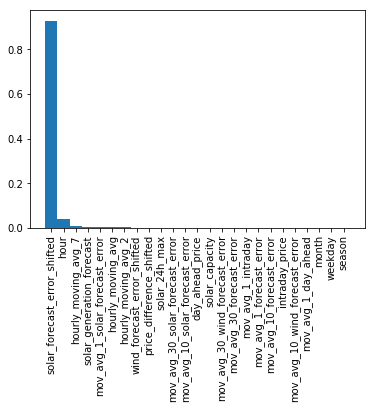

[(0.9287, 'solar_forecast_error_shifted'),
 (0.0391, 'hour'),
 (0.0078, 'hourly_moving_avg_7'),
 (0.0051, 'solar_generation_forecast'),
 (0.0047, 'mov_avg_1_solar_forecast_error'),
 (0.0026, 'hourly_moving_avg'),
 (0.0022, 'hourly_moving_avg_2'),
 (0.0009, 'wind_forecast_error_shifted')]

In [793]:
# See how important the features of the data frame are for the prediction with Random Forests

RFR = RandomForestRegressor(max_depth=7)
RFR.fit(X,y)
features = sorted(zip(map(lambda x: round(x, 4), RFR.feature_importances_), X.columns), reverse=True)
ys, labels = zip(*features)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')
plt.xticks(xs, labels, rotation='vertical')
plt.show()
features[0:8]

The solar forcast error of the previous hour has the biggest impact on the prediction of the current solar forcast error.

In [821]:
# Test Ridge Regression

scores_list = []
param_range = (0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000)

for alpha in param_range:
    RR = Ridge(alpha=alpha)
    scores_list.append(cross_validate(RR, X, y, cv=tscv, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
1.000000e-02,0.8329,175.37,77955.8,92.036,0.8299
1.000000e-01,0.8329,175.37,77955.4,92.022,0.8299
1.000000e+00,0.8329,175.37,77951.5,91.933,0.8299
1.000000e+01,0.8330,175.32,77914.0,91.850,0.8301
1.000000e+02,0.8335,174.22,77572.7,90.237,0.8311
1.000000e+03,0.8343,169.92,76602.4,83.757,0.8335
1.000000e+04,0.8349,167.92,76500.4,79.054,0.8339
1.000000e+05,0.8351,166.30,76608.5,75.175,0.8339
1.000000e+06,0.8350,164.52,76464.1,71.693,0.8339
1.000000e+07,0.8348,162.07,76594.5,65.691,0.8338


In [816]:
# AdaBoost

# Boosting: combining several weak learners to form a strong learner.
# Weak learner: Model doing slightly better than random guessing (e.g. a decision tree with low depth)
# Incorrectly predicted data points get more weight in the next step
# Regression: Weighted average (AdaBoostRegressor)

scores_list = []
param_range = [100]

ABR = AdaBoostRegressor(n_estimators=100) # Default is with DecisionTreeRegressor(max_depth=3)
scores_list.append(cross_validate(ABR, X, y, cv=tscv, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
100,0.7939,196.9,94139.5,108.088,0.7912


In [817]:
# Gradient Boosting

scores_list = []
param_range = [6]

GBR = GradientBoostingRegressor(max_depth=6) # Parameter max_features="sqrt" reduces variance, but also reduces CV score to 0.80
scores_list.append(cross_validate(GBR, X, y, cv=tscv, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
6,0.8549,138.42,71454.8,36.592,0.8544


In [819]:
# Stochastic Gradient Boosting

# Uses same method as gradient boosting, but subsample parameter is changed (default=1.0)
# See the doku of subsample parameter:
# The fraction of samples to be used for fitting the individual base learners.
# If smaller than 1.0 this results in Stochastic Gradient Boosting.
# subsample interacts with the parameter n_estimators.
# Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.

scores_list = []
param_range = [6]

SGBR = GradientBoostingRegressor(max_depth=6, subsample=0.7) # Parameter max_features="sqrt" reduces variance, but also reduces CV score to 0.80
scores_list.append(cross_validate(SGBR, X, y, cv=tscv, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
6,0.8527,139.33,74334.7,39.59,0.8519


In [818]:
# Bagging

# Short for Bootstrap Aggregation
# Voting Classifier has the same training set, but several algorithms
# In contrast, bagging uses the same algorithm, but several subsets of the training set.
# N different bootstrap samples are created from the original dataset and a model is trained on each of them.
# A bootstrap sample is created by dragging elements from the original dataset (with put back), i.e. a data point can be dragged multiple times
# With regression, the average of the predicted values is calculated

scores_list = []
param_range = [6]

BR = BaggingRegressor(RandomForestRegressor(max_depth=6))
scores_list.append(cross_validate(BR, X, y, cv=tscv, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
6,0.8578,133.78,69998.3,30.307,0.8577


By now this is the best estimator:
 - Highest expl. var.
 - Lowest mean abs. err.
 - Lowest mean squared err.
 - Close to lowest median abs. err.
 - Highest coefficient of determination (R^2)

In [804]:
BR = BaggingRegressor(RandomForestRegressor(max_depth=6), oob_score=True)
BR.fit(X,y)
BR.oob_score_

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.8684175486116088

Since the samples are sampled with putting back, some of the data points can be sampled several times, while others have never been sampled (out of bag). The letter are used to calculate the oob-score, which measures the generalization error (yields the precision of data never seen before).

### Experiment on PCA

Does not make sense here since neither computing speed needs to be imporved nor visualisation needs to be simplified

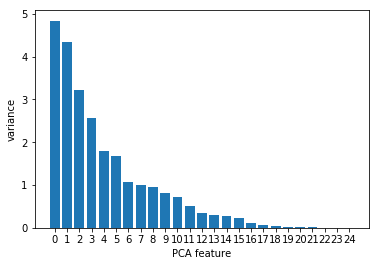

In [680]:
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit_transform(X)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()